In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/시카고 결합x/Chicago_Crimes_2012_to_2017.csv', on_bad_lines='skip')

In [ ]:
df = df.dropna(subset=['X Coordinate','Y Coordinate','Latitude', 'Longitude', 'Location'])

In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
ID,0
Case Number,0
Date,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,1226
Arrest,0


In [ ]:
#  범죄 데이터의 위도, 경도 정보를 사용해 GeoDataFrame 생성
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
crime_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # WGS84 좌표계 설정

In [ ]:
# Community Area CSV 파일 불러오기 (the_geom을 WKT 형식으로 변환)
community_areas = pd.read_csv('/content/drive/MyDrive/CommAreas_20250325.csv')  # Community Area 데이터 (CSV)
community_areas['geometry'] = community_areas['the_geom'].apply(wkt.loads)  # the_geom을 WKT로 변환
community_areas_gdf = gpd.GeoDataFrame(community_areas, geometry='geometry', crs="EPSG:4326")

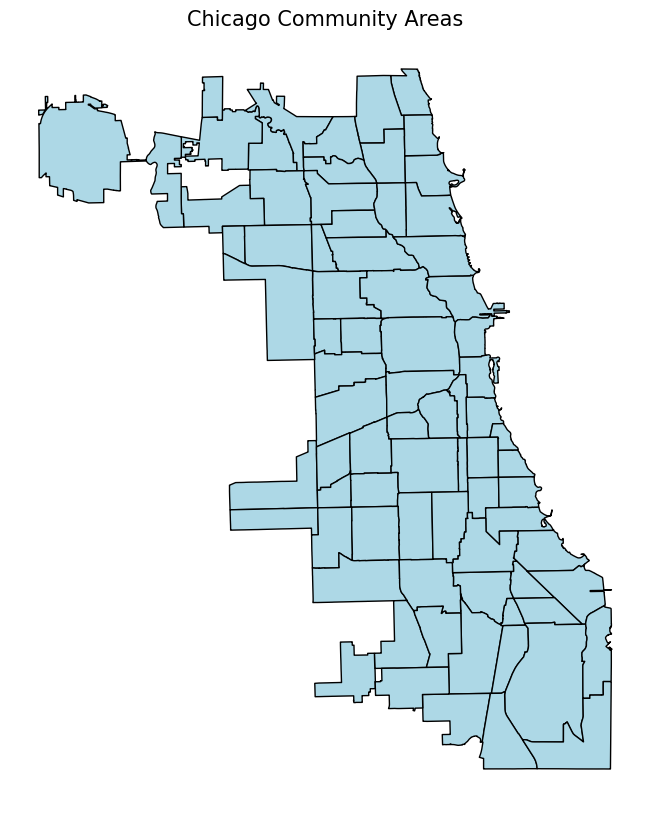

In [ ]:
import matplotlib.pyplot as plt

# Community Area 시각화
fig, ax = plt.subplots(figsize=(10, 10))  # 크기 조정
community_areas_gdf.plot(ax=ax, color='lightblue', edgecolor='black')  # 커뮤니티 영역 시각화

# 제목 추가
ax.set_title("Chicago Community Areas", fontsize=15)

# 축 숨기기
ax.set_axis_off()

# 시각화 출력
plt.show()

In [ ]:
#  2003~2015년 Ward 데이터 불러오기
wards_2003_2015 = pd.read_csv('/content/drive/MyDrive/Wards_2003_2015.csv')
wards_2003_2015['geometry'] = wards_2003_2015['the_geom'].apply(wkt.loads)
wards_2003_2015_gdf = gpd.GeoDataFrame(wards_2003_2015, geometry='geometry', crs="EPSG:4326")

In [ ]:
#  2015년 이후 Ward 데이터 불러오기
wards_2015 = pd.read_csv('/content/drive/MyDrive/WARDS_2015_20250325.csv')
wards_2015['geometry'] = wards_2015['the_geom'].apply(wkt.loads)
wards_2015_gdf = gpd.GeoDataFrame(wards_2015, geometry='geometry', crs="EPSG:4326")

In [ ]:
#  범죄 데이터를 두 개의 기간으로 분리 (2015년 기준)
crime_before_2015 = crime_gdf[crime_gdf['Date'] < '2015-01-01']
crime_after_2015 = crime_gdf[crime_gdf['Date'] >= '2015-01-01']

In [ ]:
#  2003~2015년 데이터에 대한 Spatial Join (Ward 매핑)
crime_before_2015 = gpd.sjoin(crime_before_2015, wards_2003_2015_gdf[['WARD', 'geometry']], how='left', predicate='within')

In [ ]:
#  2015년 이후 데이터에 대한 Spatial Join (Ward 매핑)
crime_after_2015 = gpd.sjoin(crime_after_2015, wards_2015_gdf[['WARD', 'geometry']], how='left', predicate='within')

In [ ]:
#  두 개의 데이터 병합
crime_with_ward = pd.concat([crime_before_2015, crime_after_2015])

In [ ]:
#
crime_with_community = gpd.sjoin(
    crime_with_ward,
    community_areas_gdf[['COMMUNITY', 'geometry']],
    how='left',
    predicate='within',
    lsuffix='_ward',
    rsuffix='_community'
)  # Community Area 매핑


In [ ]:
#  'Ward'와 'Community Area' 결측치 보완
crime_with_community['Ward'] = crime_with_community['Ward'].fillna(crime_with_community['WARD'])
crime_with_community['Community Area'] = crime_with_community['Community Area'].fillna(crime_with_community['COMMUNITY'])


In [ ]:
#  불필요한 열 삭제 (매핑된 'WARD', 'COMMUNITY' 열 제거)
crime_with_community = crime_with_community.drop(columns=['WARD', 'COMMUNITY','index_right','index__community'])

In [ ]:
crime_with_community = crime_with_community.drop(columns=['geometry'])

In [ ]:
#  결측치 확인
print(crime_with_community[['Ward', 'Community Area']].isna().sum())  # 결측치 확인

Ward              10
Community Area     3
dtype: int64


In [ ]:
crime_with_community.isna().sum()

,0
Unnamed: 0,0
ID,0
Case Number,0
Date,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,1226
Arrest,0


In [ ]:
# 11. 결과를 CSV로 저장
crime_with_community.to_csv('/content/drive/MyDrive/chicago_crime_data_with_ward_community4.csv', index=False)

In [ ]:
crime_with_community[['ID', 'Ward', 'Community Area']]

,ID,Ward,Community Area
0,10508693,24.0,29.0
1,10508695,20.0,42.0
2,10508697,37.0,25.0
3,10508698,28.0,25.0
4,10508699,28.0,25.0
...,...,...,...
1456709,10508679,28.0,30.0
1456710,10508680,17.0,69.0
1456711,10508681,15.0,66.0
1456712,10508690,7.0,46.0
